## Obtener columnas que presentan persistencia temporal y agrupación de Promedio, máximo y mínimo por hora.

En este notebook vamos a juntar los archivos de contaminnación y meoteorología de cada año en un solo archivo, y también vamos a generar columnas de informaciónn temporal para cada mediciónn y por úlitmo se va a obtener el promedio móvil de el PM10 y PM2.5. 

- __Datos recibidos:__ Limpieza de datos inicial
- __Responsable:__ Daniel Bustillos
- __Contacto:__  juandaniel.bucam@gmail.com



In [2]:
Contaminantes = ["O3","PM10mean","PM25mean"]

In [3]:
contaminante = Contaminantes[0]
contaminante

'O3'

__Pasos y descripción general del notebook__


1. Usando el archivo de correlación con retraso temporal, se crean nuevas columnas con el atributo y las horas atrás.


2. Se obtiene el promedio, máximo y mínimo por hora de todas las estaciones.


3. Generar las columna del pronóstico a 24 horas y obtener la correlación de los valores promedio máximo y mínimo con éste. Filtrar los valores más importantes.


4. Generar las columnas de pronóstico de RH, WSP TMP.



5. Generar las columnas a pronosticar de 1 hasta 23 horas.


In [4]:
import pandas as pd
pd.options.mode.chained_assignment = None 

In [5]:
data_hour_merge_24 = pd.read_csv('./datos_entrenamiento.csv')

In [6]:
contaminante = "O3"
data_hour_merge_24 = data_hour_merge_24.dropna(subset=[contaminante]).reset_index(drop=True)#PM25

In [7]:
data_hour_merge_24.head(5)

,CO,NO,NO2,NOX,O3,PM10,PM2.5,RH,SO2,TMP,WSP,dia,fecha,hora,id_station,mes,PM10mean,PM25mean
0,0.6,23.0,22.0,45.0,3.0,60.0,NaN,73.0,2.0,9.1,1.4,1.0,2015-01-01 00:00:00,0,ACO,1.0,NaN,NaN
1,0.1,0.0,5.0,5.0,32.0,NaN,NaN,NaN,1.0,NaN,7.3,1.0,2015-01-01 00:00:00,0,AJM,1.0,NaN,NaN
2,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2015-01-01 00:00:00,0,AJU,1.0,NaN,NaN
3,1.0,32.0,28.0,60.0,3.0,28.0,NaN,NaN,2.0,NaN,NaN,1.0,2015-01-01 00:00:00,0,ATI,1.0,NaN,NaN
4,1.7,NaN,NaN,NaN,1.0,46.0,32.0,NaN,4.0,NaN,NaN,1.0,2015-01-01 00:00:00,0,CAM,1.0,NaN,NaN


## 1. 
### Usando el archivo de correlación con retraso temporal, se crean nuevas columnas con el atributo y las horas atrás.


La corraloción con retraso temporal se refiere a la influencia que tienen las condiciones atmosféricas de un hora dada sobre las condiciones futuras, por ejemplo, si el nivel de contaminación de actual es alto ¿este valor influirá en la contaminación del día siguiente o la contaminación de cada día no se ve influida por valores pasados? La respuesta es la primera opción, valores pasados de las condiciones atmosféricas influyen fuertemente en la contaminación _actual_.

Esta propiedad es clave para la generación de un modelo estadístico, la existencia de patrones y de factores que aparentemente influyen en la contaminación nos permiten tener un conjunto de datos que determinen la contaminación.


La generación de la correlación se encuentra en: __/home/paw/DanielBustillos/contaminación/correlaciones_pau/correlaciones_función_paulina.ipynb__

In [8]:
target = str(contaminante + "_y")
target

'O3_y'

In [10]:
O3_corr = pd.read_csv("/DATA/paw/jupyterhub_notebook/daniel.bustillos/DanielBustillos/contaminación/pipeline-norberto/correlacion/correlaciones_"+ target +".csv") # leemo el archivo de correlación
O3_corr = O3_corr.iloc[:,1:]
O3_corr.tail()

,contaminante,valor,horas
1067,PM25mean,0.165820,44.0
1068,PM25mean,0.167111,45.0
1069,PM25mean,0.168421,46.0
1070,PM25mean,0.169548,47.0
1071,PM25mean,0.170081,48.0


- La columna "contaminante" se tiene el atributo sobre el que se realizó la correlación.
- La columna "valor" indica el valor de la correlación.
- La columna "horas" indica las horas de retraso.

Vamos a aplicar un filtro, nos quedaremos con las variables con una correlación entre -0.44 y 0.44. Este valor se eligió de forma que la cantidad de atributos final sea menor a 110:

In [11]:
if contaminante == "O3":
    threshold = 0.44
else: threshold = 0.55

In [12]:
O3_corr_filtro = O3_corr[(O3_corr.valor > threshold ) | (O3_corr.valor < - threshold) ].reset_index(drop=True)
O3_corr_filtro.shape

(108, 3)

Una vez que tenemos los contaminantes y el número de horas de retraso, definimos una función que nos genere una nueva columna con el contaminante recorrido temporalmente las horas indicadas en **O3_corr_filtro**:

In [13]:
def shit_corr(df):
    for i in range(len(O3_corr_filtro)):
        name_column = str( O3_corr_filtro.loc[i,"contaminante"] + "_" + str(
            O3_corr_filtro.loc[i,"horas"])) # se define el nombre de la columna a crear con el formato:
                                            # contaminante _ horas de retraso
        df[name_column] = df[O3_corr_filtro.loc[i,"contaminante"]].shift(
            int(float(str(O3_corr_filtro.loc[i,"horas"])))) # se toma el nombre del contaminante y se 
                                                            # desplaza temporalmente las horas indicadas
    return df.dropna()

Debido a que por cada hora se tienen tantos registros como el número de estaciones de monitoreo, existen fechas duplicadas en el df:

In [14]:
data_hour_merge_24[["fecha","id_station"]][data_hour_merge_24["fecha"]=="2015-01-01 00:00:00"].head()

,fecha,id_station
0,2015-01-01 00:00:00,ACO
1,2015-01-01 00:00:00,AJM
2,2015-01-01 00:00:00,AJU
3,2015-01-01 00:00:00,ATI
4,2015-01-01 00:00:00,CAM


Al tener fechas duplicadas, puede ocurrrir errores al aplicar el desplazamiento, por este motivo vamos a generar **un dataframe por cada estación**, aplicaremos la función y por último uniremos los dataframes:

In [15]:
estaciones = data_hour_merge_24.id_station.unique().tolist() # recolectamos los nombres de las estaciones
data_est = {}
for elem in estaciones:
    data_est[elem] = data_hour_merge_24[data_hour_merge_24.id_station == elem] #hacemos un df por estación

Aplicamos la función para cada dataframe:

In [16]:
data_shift = {}
for elem in data_est:
    data_shift[elem] = shit_corr(data_est[elem])

Unimos los dataframes:

In [17]:
df_append = pd.DataFrame(columns = data_est["MER"].columns.tolist())
for key in data_est:
    df_append = df_append.append(data_est[key], ignore_index=True,sort=True)

In [18]:
df_append.tail(5)

,CO,CO_6.0,CO_7.0,NO,NO2,NOX,NOX_30.0,NOX_31.0,NOX_6.0,NOX_7.0,...,hora_20.0,hora_21.0,hora_33.0,hora_34.0,hora_35.0,hora_43.0,hora_44.0,hora_9.0,id_station,mes
644309,0.3,0.5,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.0,12.0,0.0,23.0,22.0,14.0,13.0,0.0,MPA,8.0
644310,0.2,0.3,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,13.0,1.0,0.0,23.0,15.0,14.0,1.0,MPA,8.0
644311,0.2,0.3,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.0,14.0,2.0,1.0,0.0,16.0,15.0,2.0,MPA,8.0
644312,0.2,0.2,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,15.0,3.0,2.0,1.0,17.0,16.0,3.0,MPA,8.0
644313,0.2,0.2,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.0,16.0,4.0,3.0,2.0,18.0,17.0,4.0,MPA,8.0


# 2.
### Se obtiene el promedio, máximo y mínimo por hora de todas las estaciones.

Debido a que solo algunas estaciones miden todos los atributos con los que se está trabajando, se encontró que agrupar las condiciones atmosféricas de cada atributo con el promedio, máximo y mínimo, genera una mejora considerable al desempeño final de los modelos, debido a que al hacer esta agrupación se suavizan los valores y también se homogeniza los atributos de cada estación.

Se guardan las columnas al aplicar el groupby y se elimina "fecha":

In [19]:
cols = df_append.columns.tolist() 
cols.remove("fecha")

Aplicamos los groupbys:

In [20]:
data_hour_merge_24_mean = df_append.groupby('fecha')[cols].mean()
data_hour_merge_24_mean.reset_index(inplace=True)

In [21]:
data_hour_merge_24_max = df_append.groupby('fecha')[cols].max()
data_hour_merge_24_max.reset_index(inplace=True)

In [22]:
data_hour_merge_24_min = df_append.groupby('fecha')[cols].min()
data_hour_merge_24_min.reset_index(inplace=True)

#### Cambiamos los nombres de las estaciones:
Debido a que cada groupby genera los mismos nombres, esto puede generar problemas para identificar de qué columna se trata, se cambiarán los nombres a "contaminante_max", "contaminante_min", "contaminante_mean" según corresponda.

Se obtienenn los nonbres de las columnas en forma de lista:

In [23]:
max_columns = data_hour_merge_24_max.columns.tolist()
min_columns = data_hour_merge_24_min.columns.tolist()
mean_columns = data_hour_merge_24_mean.columns.tolist()

Se cambian los nombres en las listas:

In [24]:
for i in range(len(max_columns)):
    if max_columns[i] not in ['fecha','hora','dia','mes','id_station']:
        max_columns[i] = max_columns[i]+"_max"
        min_columns[i] = min_columns[i]+"_min"    
        mean_columns[i] = mean_columns[i]+"_mean"

Se renombra las columnas de los dataframes

In [25]:
data_hour_merge_24_mean.columns = mean_columns
data_hour_merge_24_min.columns = min_columns
data_hour_merge_24_max.columns = max_columns

Unimos los df's 

In [26]:
data_hour_merge = pd.merge(data_hour_merge_24_mean, data_hour_merge_24_max, on=['fecha'])
data_hour_merge = pd.merge(data_hour_merge, data_hour_merge_24_min, on=['fecha'])

Debido a que el proceso de obtener el máximo y mínimo es lento, es conveniente guardar el archivo de manera provisional:

In [27]:
contaminante ="O3"
data_hour_merge.to_csv("./datos_gb_" + contaminante + ".csv", sep=',', encoding='utf-8',index=False)

# Leamos el archivo:

In [62]:
data_hour_merge = pd.read_csv("./datos_gb_" + contaminante + ".csv", sep=',', encoding='utf-8')

In [63]:
data_hour_merge = data_hour_merge.sort_values(['fecha',"hora_x"], ascending=[0,1]).reset_index(drop=True)

## 3. 
### Generar las columna a pronosticar y obtener la correlación de los valores promedio máximo y mínimo con éste. Filtrar los valores más importantes.


Ahora vamos a sacar los atributos más correlacionado con el contaminante a pronosticar a pronosticar. 

In [64]:
if contaminante == 'PM10' or contaminante == 'PM2.5':
    item = contaminante+"mean_max"
else:
    item = contaminante+"_max" 
print(item)

O3_max


Desplazamos el target **24 horas** en adelante, esta columna nos indica el valor de contaminación que tomó a partir de condiciones atmosféricas 24 horas atrás. Este será nuesta columna a pronosticar.

In [65]:
data_hour_merge[str(item+"_frcst_"+str(24))] = data_hour_merge[item].shift(24)

In [66]:
target = str(item+"_frcst_"+ str(24))
print(target)

O3_max_frcst_24


In [67]:
data_hour_merge.head()

,fecha,CO_mean,CO_6.0_mean,CO_7.0_mean,NO_mean,NO2_mean,NOX_mean,NOX_30.0_mean,NOX_31.0_mean,NOX_6.0_mean,...,hora_21.0_min,hora_33.0_min,hora_34.0_min,hora_35.0_min,hora_43.0_min,hora_44.0_min,hora_9.0_min,id_station_y,mes_y,O3_max_frcst_24
0,2017-08-05 14:00:00,0.400000,0.650000,0.575000,1.714286,17.000000,18.571429,47.142857,49.428571,57.571429,...,15.0,3.0,2.0,1.0,0.0,10.0,4.0,ACO,8.0,NaN
1,2017-08-05 13:00:00,0.430769,0.576923,0.446154,3.190476,19.047619,22.285714,55.863636,41.000000,53.090909,...,13.0,1.0,0.0,0.0,0.0,0.0,1.0,ACO,8.0,NaN
2,2017-08-05 12:00:00,0.488000,0.448000,0.404000,6.809524,24.333333,31.190476,42.142857,35.904762,45.809524,...,13.0,1.0,0.0,0.0,9.0,8.0,2.0,ACO,8.0,NaN
3,2017-08-05 11:00:00,0.538462,0.403846,0.384615,11.181818,26.227273,37.318182,35.136364,26.363636,38.863636,...,9.0,0.0,0.0,0.0,8.0,7.0,1.0,ACO,8.0,NaN
4,2017-08-05 10:00:00,0.553846,0.384615,0.365385,17.681818,25.500000,43.318182,26.363636,22.380952,32.818182,...,8.0,0.0,0.0,18.0,7.0,6.0,0.0,ACO,8.0,NaN


## 4. 
### Generar las columnas de pronóstico de RH, WSP TMP.

Se observó que usando datos de pronóstico atmosférico, el modelo tiene un mejor desempeño, vamos a añadir "RH_mean","WSP_mean","TMP_mean" a los atributos con un pronóstico de 24 horas.

volvamos a sacar la correlación y filtramos los valores de correlación:

In [68]:
if contaminante == "O3":
    threshold = 0.44
else: threshold = 0.55

In [69]:
data_corr_2 = data_hour_merge.corr()
variables_mas_correlacionadas_con_pronóstico = data_corr_2[target][(data_corr_2[target] > threshold) |                                                                
                                                            (data_corr_2[target] < - threshold)].index.tolist()

Agregamos a las columnas mas correlacionadas los atributos de pronóstico:

In [70]:
variables_mas_correlacionadas_con_pronóstico.append("O3_max")
variables_mas_correlacionadas_con_pronóstico.append("fecha")

variables_mas_correlacionadas_con_pronóstico = list(set(variables_mas_correlacionadas_con_pronóstico))

In [71]:
data_hour_merge = data_hour_merge[variables_mas_correlacionadas_con_pronóstico]

## 5. 
### Generar las columnas a pronosticar de 1 hasta 23 horas.


Al tratarse de modelos supervisados, es necesario tener como columna cada uno de los valores a pronosticar, esta columna es la columna del contaminante recorrido desde 1 hasta 24 horas atrás:

Definimos el contaminante que estamos usando:

In [72]:
if contaminante == 'PM10' or contaminante == 'PM2.5':
    item = contaminante+"mean_max"
else:
    item = contaminante+"_max" 
print(item)

O3_max


In [73]:
for i in range(1, 24):
    col_name = str(item+"_frcst_"+str(i))
    data_hour_merge[col_name] = data_hour_merge[item].shift(i)
    if i==range(1, 24)[-1]:
        print(i)
data_hour_merge.dropna(inplace=True)

23


Guardemos:

In [74]:
data_hour_merge.to_csv("./datos_modelos_"+ contaminante + ".csv",sep=',', encoding='utf-8',index=False)

In [75]:
data_hour_merge.columns.tolist()

['TMP_24.0_mean',
 'O3_3.0_max',
 'RH_24.0_mean',
 'O3_44.0_max',
 'hora_35.0_mean',
 'hora_9.0_mean',
 'O3_2.0_max',
 'O3_1.0_mean',
 'hora_10.0_max',
 'TMP_1.0_mean',
 'TMP_47.0_max',
 'TMP_21.0_max',
 'O3_0.0_min',
 'O3_max_frcst_24',
 'hora_19.0_min',
 'TMP_23.0_mean',
 'RH_25.0_mean',
 'RH_47.0_max',
 'RH_22.0_max',
 'RH_45.0_mean',
 'TMP_min',
 'NO_7.0_max',
 'NO_8.0_max',
 'TMP_21.0_mean',
 'TMP_46.0_mean',
 'hora_34.0_min',
 'RH_21.0_max',
 'RH_2.0_min',
 'O3_1.0_min',
 'NO_8.0_mean',
 'hora_21.0_mean',
 'O3_mean',
 'hora_11.0_mean',
 'RH_2.0_max',
 'RH_48.0_mean',
 'O3_21.0_min',
 'O3_2.0_min',
 'O3_0.0_mean',
 'O3_45.0_min',
 'RH_22.0_min',
 'TMP_46.0_min',
 'TMP_22.0_min',
 'RH_1.0_max',
 'RH_24.0_min',
 'O3_max',
 'O3_21.0_mean',
 'RH_23.0_max',
 'hora_19.0_mean',
 'O3_23.0_mean',
 'O3_24.0_max',
 'NOX_7.0_mean',
 'RH_23.0_mean',
 'O3_3.0_mean',
 'TMP_48.0_max',
 'TMP_45.0_max',
 'TMP_48.0_mean',
 'O3_46.0_max',
 'O3_21.0_max',
 'O3_48.0_max',
 'TMP_25.0_mean',
 'fecha',
 '

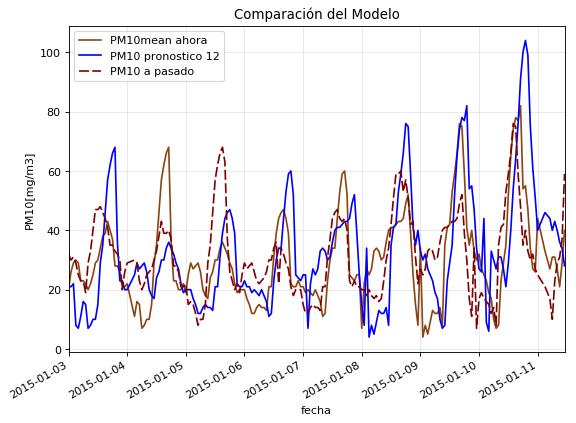

In [79]:
data_hour_merge['fecha'] =  pd.to_datetime(data_hour_merge['fecha'], format='%Y-%m-%d %H:%M')

import matplotlib.pyplot as plt

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.gca()

# df_export.(50).plot(x="fecha", y=[ "O3_y"],ax=ax,label=["O3 Medido"],color="dodgerblue")
# df_export.(60).head(100).plot(x="fecha", y=["O3_y_frcst_6"],ax=ax,label=["Pronóstico O3 a 12 horas"],color='darkblue',dashes=[6, 2])

data_hour_merge.tail(200).plot(x="fecha", y=["O3_max"],ax=ax,label=["PM10mean ahora"],color="saddlebrown")
data_hour_merge.tail(200).plot(x="fecha", y=["O3_max_frcst_22"],ax=ax,label=["PM10 pronostico 12"],color="blue")
data_hour_merge.tail(200).plot(x="fecha", y=["O3_22.0_max"],ax=ax,label=["PM10 a pasado"],color='maroon',dashes=[6, 2])

plt.ylabel("PM10[mg/m3]")
plt.title("Comparación del Modelo")


# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.01)
ax.grid(which='major', alpha=0.3)



plt.legend()
plt.show()

In [77]:
data_hour_merge.columns.tolist()

['TMP_24.0_mean',
 'O3_3.0_max',
 'RH_24.0_mean',
 'O3_44.0_max',
 'hora_35.0_mean',
 'hora_9.0_mean',
 'O3_2.0_max',
 'O3_1.0_mean',
 'hora_10.0_max',
 'TMP_1.0_mean',
 'TMP_47.0_max',
 'TMP_21.0_max',
 'O3_0.0_min',
 'O3_max_frcst_24',
 'hora_19.0_min',
 'TMP_23.0_mean',
 'RH_25.0_mean',
 'RH_47.0_max',
 'RH_22.0_max',
 'RH_45.0_mean',
 'TMP_min',
 'NO_7.0_max',
 'NO_8.0_max',
 'TMP_21.0_mean',
 'TMP_46.0_mean',
 'hora_34.0_min',
 'RH_21.0_max',
 'RH_2.0_min',
 'O3_1.0_min',
 'NO_8.0_mean',
 'hora_21.0_mean',
 'O3_mean',
 'hora_11.0_mean',
 'RH_2.0_max',
 'RH_48.0_mean',
 'O3_21.0_min',
 'O3_2.0_min',
 'O3_0.0_mean',
 'O3_45.0_min',
 'RH_22.0_min',
 'TMP_46.0_min',
 'TMP_22.0_min',
 'RH_1.0_max',
 'RH_24.0_min',
 'O3_max',
 'O3_21.0_mean',
 'RH_23.0_max',
 'hora_19.0_mean',
 'O3_23.0_mean',
 'O3_24.0_max',
 'NOX_7.0_mean',
 'RH_23.0_mean',
 'O3_3.0_mean',
 'TMP_48.0_max',
 'TMP_45.0_max',
 'TMP_48.0_mean',
 'O3_46.0_max',
 'O3_21.0_max',
 'O3_48.0_max',
 'TMP_25.0_mean',
 'fecha',
 '